# Starbucks Capstone Challenge

## Introduction

This data set contains simulated data that mimics customer behavior on the Starbucks rewards mobile app. Once every few days, Starbucks sends out an offer to users of the mobile app. An offer can be merely an advertisement for a drink or an actual offer such as a discount or BOGO (buy one get one free). Some users might not receive any offer during certain weeks. 

Not all users receive the same offer, and that is the challenge to solve with this data set.

*The project goal* is to combine transaction, demographic and offer data to **determine which demographic groups respond best to which offer type**. This data set is a simplified version of the real Starbucks app because the underlying simulator only has one product whereas Starbucks actually sells dozens of products.

## Data Sets

The data is contained in three files:

* portfolio.json - containing offer ids and meta data about each offer (duration, type, etc.)
* profile.json - demographic data for each customer
* transcript.json - records for transactions, offers received, offers viewed, and offers completed

Here is the schema and explanation of each variable in the files:

**portfolio.json**
* id (string) - offer id
* offer_type (string) - type of offer ie BOGO, discount, informational
* difficulty (int) - minimum required spend to complete an offer
* reward (int) - reward given for completing an offer
* duration (int) - time for offer to be open, in days
* channels (list of strings)

**profile.json**
* age (int) - age of the customer 
* became_member_on (int) - date when customer created an app account
* gender (str) - gender of the customer (note some entries contain 'O' for other rather than M or F)
* id (str) - customer id
* income (float) - customer's income

**transcript.json**
* event (str) - record description (ie transaction, offer received, offer viewed, etc.)
* person (str) - customer id
* time (int) - time in hours since start of test. The data begins at time t=0
* value - (dict of strings) - either an offer id or transaction amount depending on the record


# A. Project Deliverables 

1. Identify which groups of people are most responsive to each type of offer  
2. What type offers really excite people?
3. How best to present each type of offer?

In [1]:
import pandas as pd
import numpy as np
import seaborn as sns
import math
import json
import datetime
from itertools import chain

from sklearn.model_selection import train_test_split
from sklearn.pipeline import make_pipeline
from sklearn.preprocessing import StandardScaler
from sklearn.linear_model import LogisticRegression
from sklearn.model_selection import cross_validate
from sklearn.model_selection import cross_val_predict
from sklearn.metrics import precision_recall_curve
from sklearn import metrics
from sklearn.metrics import classification_report, confusion_matrix

import matplotlib.pyplot as plt
from plotly.subplots import make_subplots
import plotly.graph_objects as go
import warnings

%matplotlib inline
warnings.filterwarnings("ignore")

# B. Data Wrangling 

## B1. Import data sets

In [2]:
# read in the json files
portfolio = pd.read_json('data/portfolio.json', orient='records', lines=True)
profile = pd.read_json('data/profile.json', orient='records', lines=True)
transcript = pd.read_json('data/transcript.json', orient='records', lines=True)

In [3]:
portfolio.head()

reward                      channels  difficulty  duration     offer_type  \
0      10       [email, mobile, social]          10         7           bogo   
1      10  [web, email, mobile, social]          10         5           bogo   
2       0          [web, email, mobile]           0         4  informational   
3       5          [web, email, mobile]           5         7           bogo   
4       5                  [web, email]          20        10       discount   

                                 id  
0  ae264e3637204a6fb9bb56bc8210ddfd  
1  4d5c57ea9a6940dd891ad53e9dbe8da0  
2  3f207df678b143eea3cee63160fa8bed  
3  9b98b8c7a33c4b65b9aebfe6a799e6d9  
4  0b1e1539f2cc45b7b9fa7c272da2e1d7

In [4]:
profile.head()

gender  age                                id  became_member_on    income
0   None  118  68be06ca386d4c31939f3a4f0e3dd783          20170212       NaN
1      F   55  0610b486422d4921ae7d2bf64640c50b          20170715  112000.0
2   None  118  38fe809add3b4fcf9315a9694bb96ff5          20180712       NaN
3      F   75  78afa995795e4d85b5d9ceeca43f5fef          20170509  100000.0
4   None  118  a03223e636434f42ac4c3df47e8bac43          20170804       NaN

In [5]:
transcript.head()

person           event  \
0  78afa995795e4d85b5d9ceeca43f5fef  offer received   
1  a03223e636434f42ac4c3df47e8bac43  offer received   
2  e2127556f4f64592b11af22de27a7932  offer received   
3  8ec6ce2a7e7949b1bf142def7d0e0586  offer received   
4  68617ca6246f4fbc85e91a2a49552598  offer received   

                                              value  time  
0  {'offer id': '9b98b8c7a33c4b65b9aebfe6a799e6d9'}     0  
1  {'offer id': '0b1e1539f2cc45b7b9fa7c272da2e1d7'}     0  
2  {'offer id': '2906b810c7d4411798c6938adc9daaa5'}     0  
3  {'offer id': 'fafdcd668e3743c1bb461111dcafc2a4'}     0  
4  {'offer id': '4d5c57ea9a6940dd891ad53e9dbe8da0'}     0

**Note**
- profile and transcript share: user (id and person)
- portfolio and transcript share: offer id

## Main Action Items List
- create dummy variables where data type is complicated first 
- merge all 3 data sets as there are shared columns, to have clean enough data sets to work with
- again, create dummy varialbes where applicable for grouping purpose

## B2. Portfolio

In [6]:
portfolio.head()

reward                      channels  difficulty  duration     offer_type  \
0      10       [email, mobile, social]          10         7           bogo   
1      10  [web, email, mobile, social]          10         5           bogo   
2       0          [web, email, mobile]           0         4  informational   
3       5          [web, email, mobile]           5         7           bogo   
4       5                  [web, email]          20        10       discount   

                                 id  
0  ae264e3637204a6fb9bb56bc8210ddfd  
1  4d5c57ea9a6940dd891ad53e9dbe8da0  
2  3f207df678b143eea3cee63160fa8bed  
3  9b98b8c7a33c4b65b9aebfe6a799e6d9  
4  0b1e1539f2cc45b7b9fa7c272da2e1d7

In [7]:
portfolio.describe()

reward  difficulty   duration
count  10.000000   10.000000  10.000000
mean    4.200000    7.700000   6.500000
std     3.583915    5.831905   2.321398
min     0.000000    0.000000   3.000000
25%     2.000000    5.000000   5.000000
50%     4.000000    8.500000   7.000000
75%     5.000000   10.000000   7.000000
max    10.000000   20.000000  10.000000

**Note**
- rename the 'id' column to 'offer_id'
- dummy 'channels' and 'off_type' columns

In [8]:
# change id column name to offer_id
portfolio.rename(columns={'id':'offer_id'}, inplace=True)

# Dummy the channels column
channel_dummies = pd.get_dummies(portfolio['channels'].apply(pd.Series).stack(), prefix='channel').sum(level=0)

# drop the orignial channel column and concatenate the dummies ones
portfolio = pd.concat([portfolio,channel_dummies],axis=1)
portfolio.drop('channels', axis=1, inplace=True)

portfolio

reward  difficulty  duration     offer_type  \
0      10          10         7           bogo   
1      10          10         5           bogo   
2       0           0         4  informational   
3       5           5         7           bogo   
4       5          20        10       discount   
5       3           7         7       discount   
6       2          10        10       discount   
7       0           0         3  informational   
8       5           5         5           bogo   
9       2          10         7       discount   

                           offer_id  channel_email  channel_mobile  \
0  ae264e3637204a6fb9bb56bc8210ddfd              1               1   
1  4d5c57ea9a6940dd891ad53e9dbe8da0              1               1   
2  3f207df678b143eea3cee63160fa8bed              1               1   
3  9b98b8c7a33c4b65b9aebfe6a799e6d9              1               1   
4  0b1e1539f2cc45b7b9fa7c272da2e1d7              1               0   
5  2298d6c36e964ae4a3e7e9706d1fb8c2              1               1   
6  fafdcd668e3743c1bb461111dcafc2a4              1               1   
7  5a8bc65990b245e5a138643cd4eb9837              1               1   
8  f19421c1d4aa40978ebb69ca19b0e20d              1               1   
9  2906b810c7d4411798c6938adc9daaa5              1               1   

   channel_social  channel_web  
0               1            0  
1               1            1  
2               0            1  
3               0            1  
4               0            1  
5               1            1  
6               1            1  
7               1            0  
8               1            1  
9               0            1

## B2. Profile

In [9]:
profile.head()

gender  age                                id  became_member_on    income
0   None  118  68be06ca386d4c31939f3a4f0e3dd783          20170212       NaN
1      F   55  0610b486422d4921ae7d2bf64640c50b          20170715  112000.0
2   None  118  38fe809add3b4fcf9315a9694bb96ff5          20180712       NaN
3      F   75  78afa995795e4d85b5d9ceeca43f5fef          20170509  100000.0
4   None  118  a03223e636434f42ac4c3df47e8bac43          20170804       NaN

In [10]:
profile.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 17000 entries, 0 to 16999
Data columns (total 5 columns):
 #   Column            Non-Null Count  Dtype  
---  ------            --------------  -----  
 0   gender            14825 non-null  object 
 1   age               17000 non-null  int64  
 2   id                17000 non-null  object 
 3   became_member_on  17000 non-null  int64  
 4   income            14825 non-null  float64
dtypes: float64(1), int64(2), object(2)
memory usage: 664.2+ KB


In [11]:
profile.describe()

age  became_member_on         income
count  17000.000000      1.700000e+04   14825.000000
mean      62.531412      2.016703e+07   65404.991568
std       26.738580      1.167750e+04   21598.299410
min       18.000000      2.013073e+07   30000.000000
25%       45.000000      2.016053e+07   49000.000000
50%       58.000000      2.017080e+07   64000.000000
75%       73.000000      2.017123e+07   80000.000000
max      118.000000      2.018073e+07  120000.000000

In [12]:
profile.isnull().sum()

gender              2175
age                    0
id                     0
became_member_on       0
income              2175
dtype: int64

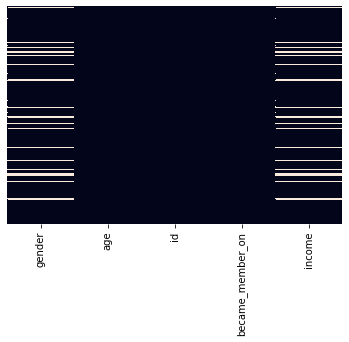

In [13]:
sns.heatmap(profile.isnull(),yticklabels=False,cbar=False)

**Note**
- rename 'id' to'customer id'
- the same incomplete profiles are missing 'gender' and 'income' info
    - can compute 'income' relative to age range
    - can compute 'gender' into M/F/Unspecified -> dummy
- age: max is 118
    - explore the values, then replace irregular values with appropriate values
    - can group the age into different buckets
- convert 'became_member_on' to date format
    - also consider if year is informative enough -> dummy

### B2.a. Time joined the app

In [14]:
# rename 'id' to 'customer_id'
profile.rename(columns={'id':'customer_id'},inplace=True)
 
# convert date format
profile['became_member_on'] = pd.to_datetime(profile['became_member_on'], format='%Y%m%d')

profile.head()

gender  age                       customer_id became_member_on    income
0   None  118  68be06ca386d4c31939f3a4f0e3dd783       2017-02-12       NaN
1      F   55  0610b486422d4921ae7d2bf64640c50b       2017-07-15  112000.0
2   None  118  38fe809add3b4fcf9315a9694bb96ff5       2018-07-12       NaN
3      F   75  78afa995795e4d85b5d9ceeca43f5fef       2017-05-09  100000.0
4   None  118  a03223e636434f42ac4c3df47e8bac43       2017-08-04       NaN

### B2.b. Gender

In [20]:
# gender values
profile['gender'].value_counts()

M    8484
F    6129
O     212
Name: gender, dtype: int64

In [15]:
# fill missing values with 'unspecified'
profile['gender'] = profile['gender'].fillna('unspecified')

profile.head()

gender  age                       customer_id became_member_on  \
0  unspecified  118  68be06ca386d4c31939f3a4f0e3dd783       2017-02-12   
1            F   55  0610b486422d4921ae7d2bf64640c50b       2017-07-15   
2  unspecified  118  38fe809add3b4fcf9315a9694bb96ff5       2018-07-12   
3            F   75  78afa995795e4d85b5d9ceeca43f5fef       2017-05-09   
4  unspecified  118  a03223e636434f42ac4c3df47e8bac43       2017-08-04   

     income  
0       NaN  
1  112000.0  
2       NaN  
3  100000.0  
4       NaN

### B2.c. Age and Income

In [16]:
# Age stats
profile['age'].describe()

count    17000.000000
mean        62.531412
std         26.738580
min         18.000000
25%         45.000000
50%         58.000000
75%         73.000000
max        118.000000
Name: age, dtype: float64

In [17]:
# number of unique age
profile['age'].nunique()

85

In [18]:
# unique age
profile['age'].unique()

array([118,  55,  75,  68,  65,  58,  61,  26,  62,  49,  57,  40,  64,
        78,  42,  56,  33,  46,  59,  67,  53,  22,  96,  69,  20,  45,
        54,  39,  41,  79,  66,  29,  44,  63,  36,  76,  77,  30,  51,
        27,  73,  74,  70,  89,  50,  90,  60,  19,  72,  52,  18,  71,
        83,  43,  47,  32,  38,  34,  85,  48,  35,  82,  21,  24,  81,
        25,  37,  23, 100,  28,  84,  80,  87,  86,  94,  31,  88,  95,
        93,  91,  92,  98, 101,  97,  99])

In [19]:
profile['age'].value_counts()

118    2175
58      408
53      372
51      363
54      359
       ... 
100      12
96        8
98        5
99        5
101       5
Name: age, Length: 85, dtype: int64

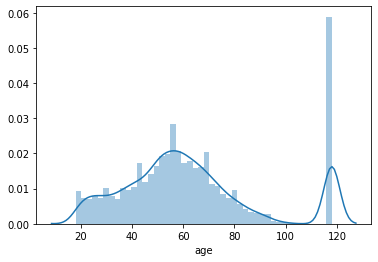

In [20]:
# Distribution of customer age
sns.distplot(profile['age'])

In [21]:
# Income Stats
profile['income'].describe()

count     14825.000000
mean      65404.991568
std       21598.299410
min       30000.000000
25%       49000.000000
50%       64000.000000
75%       80000.000000
max      120000.000000
Name: income, dtype: float64

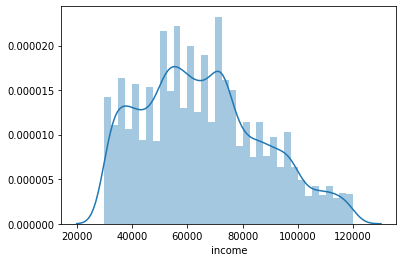

In [22]:
# Income distribution
sns.distplot(profile['income'])

**Insights**
- Consider age of 100, 101 and 118 are abnormal, can I consider them as outliers and drop from analysis? 
- Outlier rule of thum is >3 std. 3std in age distribution: 3(26.74) = 80.22
- From income stats, the saraly min is 30K, max is 120K, average is 64K. It is reasonable to use the average income to compute for mising values.
- However, are the missing values associated with users who are older than 100 years old?

### B2.d. Abnormal age

In [23]:
abnorm_age = [100,101,118]

abnorm = profile[profile['age'].isin(abnorm_age)]

print(abnorm.shape)
abnorm.head()

(2192, 5)


gender  age                       customer_id became_member_on  income
0  unspecified  118  68be06ca386d4c31939f3a4f0e3dd783       2017-02-12     NaN
2  unspecified  118  38fe809add3b4fcf9315a9694bb96ff5       2018-07-12     NaN
4  unspecified  118  a03223e636434f42ac4c3df47e8bac43       2017-08-04     NaN
6  unspecified  118  8ec6ce2a7e7949b1bf142def7d0e0586       2017-09-25     NaN
7  unspecified  118  68617ca6246f4fbc85e91a2a49552598       2017-10-02     NaN

In [24]:
# portion of abnormal age in the dataset
abnorm.shape[0]/profile.shape[0]

0.12894117647058823

In [25]:
abnorm.groupby(['age','income']).count()

gender  customer_id  became_member_on
age income                                         
100 42000.0        1            1                 1
    47000.0        1            1                 1
    63000.0        2            2                 2
    70000.0        1            1                 1
    71000.0        2            2                 2
    83000.0        1            1                 1
    96000.0        1            1                 1
    98000.0        1            1                 1
    109000.0       1            1                 1
    118000.0       1            1                 1
101 43000.0        1            1                 1
    56000.0        1            1                 1
    59000.0        1            1                 1
    82000.0        1            1                 1
    99000.0        1            1                 1

In [26]:
abnorm['income'].nunique()

15

**Questions:** 
- are all 118-yr users don't have income?
- are all NaN income from profile df associates with 118-yr users?
- what is the percentage of 118-yr user in the df?

In [27]:
# total 118-yr users
abnorm['age'].value_counts() # agreed with profile df

118    2175
100      12
101       5
Name: age, dtype: int64

In [28]:
# total nul values for income
abnorm['income'].isnull().sum() # agreed with profile df

2175

In [29]:
# what about their gender?
abnorm.groupby(['age','gender']).count() # agreed with profile df

customer_id  became_member_on  income
age gender                                            
100 F                      9                 9       9
    M                      2                 2       2
    O                      1                 1       1
101 F                      5                 5       5
118 unspecified         2175              2175       0

In [30]:
# Portion of 118-yr users
percent118 = len(profile[profile['age']==118])/profile.shape[0]*100
percent118

12.794117647058822

In [31]:
print('There are {} users who are 118 years old.'.format(abnorm['age'].value_counts()[118]))
print('There are {} users who do not provide income.'.format(profile['income'].isnull().sum()))
print('There are {} users who do not provide gender.'.format(abnorm[abnorm['gender']=='unspecified'].shape[0]))
print('Percentage of people whose age is 118 is: {}%'.format(round(percent118,2)))
print('Percentage of people who is older than 100 is: {}%'.format(round(abnorm.shape[0]/profile.shape[0]*100, 2)))

There are 2175 users who are 118 years old.
There are 2175 users who do not provide income.
There are 2175 users who do not provide gender.
Percentage of people whose age is 118 is: 12.79%
Percentage of people who is older than 100 is: 12.89%


### B2.e. Findings on Profile dataset

After exploring the data, I conclude that the abnormal users have these attributes:
- 118 years old 
- don't have income
- gender is unspecified

I consider all users who are older than 100 years old as outliers since these ages are greater than 3 std.dev in age distribution, and there is not a significant amount (0.10%) of 118-yr vs >100-yr sample sizes. Therefore, 
- I'm not going to compute missing income
- I'm going to remove them from the data set later after merging all data sets

## B3. Transcript

Data description
- person: (string/hash)
- event: (string) offer received, offer viewed, transaction, offer completed
- value: (dictionary) different values depending on event type
- offer id: (string/hash) not associated with any "transaction"
- amount: (numeric) money spent in "transaction"
- reward: (numeric) money gained from "offer completed"
- time: (numeric) hours after start of test

In [32]:
transcript.head()

person           event  \
0  78afa995795e4d85b5d9ceeca43f5fef  offer received   
1  a03223e636434f42ac4c3df47e8bac43  offer received   
2  e2127556f4f64592b11af22de27a7932  offer received   
3  8ec6ce2a7e7949b1bf142def7d0e0586  offer received   
4  68617ca6246f4fbc85e91a2a49552598  offer received   

                                              value  time  
0  {'offer id': '9b98b8c7a33c4b65b9aebfe6a799e6d9'}     0  
1  {'offer id': '0b1e1539f2cc45b7b9fa7c272da2e1d7'}     0  
2  {'offer id': '2906b810c7d4411798c6938adc9daaa5'}     0  
3  {'offer id': 'fafdcd668e3743c1bb461111dcafc2a4'}     0  
4  {'offer id': '4d5c57ea9a6940dd891ad53e9dbe8da0'}     0

In [33]:
transcript.describe()

time
count  306534.000000
mean      366.382940
std       200.326314
min         0.000000
25%       186.000000
50%       408.000000
75%       528.000000
max       714.000000

In [34]:
transcript.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 306534 entries, 0 to 306533
Data columns (total 4 columns):
 #   Column  Non-Null Count   Dtype 
---  ------  --------------   ----- 
 0   person  306534 non-null  object
 1   event   306534 non-null  object
 2   value   306534 non-null  object
 3   time    306534 non-null  int64 
dtypes: int64(1), object(3)
memory usage: 9.4+ MB


**Note**
- rename 'person' to 'customer_id'
- convert time from hour to day
- dummy 'event' and 'value' 

### B3.a. Time

In [35]:
# rename 'person' to 'customer_id'
transcript.rename(columns={'person':'customer_id'},inplace=True)

# convert time
transcript['day'] = transcript['time'].apply(lambda x: int(x / 24) + (x % 24 > 0))
transcript.drop('time',axis=1,inplace=True)

transcript

customer_id           event  \
0       78afa995795e4d85b5d9ceeca43f5fef  offer received   
1       a03223e636434f42ac4c3df47e8bac43  offer received   
2       e2127556f4f64592b11af22de27a7932  offer received   
3       8ec6ce2a7e7949b1bf142def7d0e0586  offer received   
4       68617ca6246f4fbc85e91a2a49552598  offer received   
...                                  ...             ...   
306529  b3a1272bc9904337b331bf348c3e8c17     transaction   
306530  68213b08d99a4ae1b0dcb72aebd9aa35     transaction   
306531  a00058cf10334a308c68e7631c529907     transaction   
306532  76ddbd6576844afe811f1a3c0fbb5bec     transaction   
306533  c02b10e8752c4d8e9b73f918558531f7     transaction   

                                                   value  day  
0       {'offer id': '9b98b8c7a33c4b65b9aebfe6a799e6d9'}    0  
1       {'offer id': '0b1e1539f2cc45b7b9fa7c272da2e1d7'}    0  
2       {'offer id': '2906b810c7d4411798c6938adc9daaa5'}    0  
3       {'offer id': 'fafdcd668e3743c1bb461111dcafc2a4'}    0  
4       {'offer id': '4d5c57ea9a6940dd891ad53e9dbe8da0'}    0  
...                                                  ...  ...  
306529                    {'amount': 1.5899999999999999}   30  
306530                                  {'amount': 9.53}   30  
306531                                  {'amount': 3.61}   30  
306532                    {'amount': 3.5300000000000002}   30  
306533                                  {'amount': 4.05}   30  

[306534 rows x 4 columns]

In [36]:
# 'day' stats
transcript['day'].describe()

count    306534.000000
mean         15.540942
std           8.368843
min           0.000000
25%           8.000000
50%          17.000000
75%          22.000000
max          30.000000
Name: day, dtype: float64

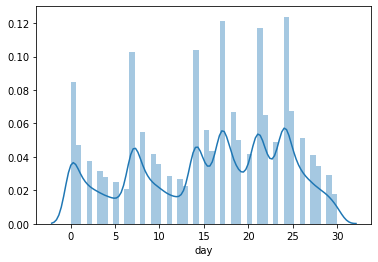

In [37]:
# time distribution
sns.distplot(transcript['day'])

### B3.b. Value: {'offer type' : 'offer value'}

In [38]:
transcript['value'] # it contains many dictionaries

0         {'offer id': '9b98b8c7a33c4b65b9aebfe6a799e6d9'}
1         {'offer id': '0b1e1539f2cc45b7b9fa7c272da2e1d7'}
2         {'offer id': '2906b810c7d4411798c6938adc9daaa5'}
3         {'offer id': 'fafdcd668e3743c1bb461111dcafc2a4'}
4         {'offer id': '4d5c57ea9a6940dd891ad53e9dbe8da0'}
                                ...                       
306529                      {'amount': 1.5899999999999999}
306530                                    {'amount': 9.53}
306531                                    {'amount': 3.61}
306532                      {'amount': 3.5300000000000002}
306533                                    {'amount': 4.05}
Name: value, Length: 306534, dtype: object

In [39]:
# What are the keys? 

def uniqueKeys(arr):
    key = list(set(key for dic in arr for key in dic.keys()))
    return key

uniqueKeys(transcript['value'])

['amount', 'offer_id', 'offer id', 'reward']

In [40]:
# create 'offer_id' col
transcript['offer_id'] = [list(x.values())[0]  if (list(x.keys())[0] in ['offer_id', 'offer id']) else np.nan for x in transcript['value']]
# create 'amount' col
transcript['amount'] = [list(x.values())[0]  if (list(x.keys())[0] in ['amount']) else np.nan for x in transcript['value']]

transcript.drop(columns=['value'],inplace=True)
transcript.head()

customer_id           event  day  \
0  78afa995795e4d85b5d9ceeca43f5fef  offer received    0   
1  a03223e636434f42ac4c3df47e8bac43  offer received    0   
2  e2127556f4f64592b11af22de27a7932  offer received    0   
3  8ec6ce2a7e7949b1bf142def7d0e0586  offer received    0   
4  68617ca6246f4fbc85e91a2a49552598  offer received    0   

                           offer_id  amount  
0  9b98b8c7a33c4b65b9aebfe6a799e6d9     NaN  
1  0b1e1539f2cc45b7b9fa7c272da2e1d7     NaN  
2  2906b810c7d4411798c6938adc9daaa5     NaN  
3  fafdcd668e3743c1bb461111dcafc2a4     NaN  
4  4d5c57ea9a6940dd891ad53e9dbe8da0     NaN

**Insights**
- For offer_id in words, they are the id of the offer. No transaction is made by the customer
- For offer_id as NaN, they are the reward or amount. The associated values are amount in dollars 

I can split the customers into 2 groups then study their interaction with the type of offers (BOGO, discout, informational) they receive:
- group 1: customers receive offers
- gorup 2: customers make transactions (no associated offer_id)

## B4. Merge all the data sets

In [41]:
print(portfolio.shape)
portfolio

(10, 9)


reward  difficulty  duration     offer_type  \
0      10          10         7           bogo   
1      10          10         5           bogo   
2       0           0         4  informational   
3       5           5         7           bogo   
4       5          20        10       discount   
5       3           7         7       discount   
6       2          10        10       discount   
7       0           0         3  informational   
8       5           5         5           bogo   
9       2          10         7       discount   

                           offer_id  channel_email  channel_mobile  \
0  ae264e3637204a6fb9bb56bc8210ddfd              1               1   
1  4d5c57ea9a6940dd891ad53e9dbe8da0              1               1   
2  3f207df678b143eea3cee63160fa8bed              1               1   
3  9b98b8c7a33c4b65b9aebfe6a799e6d9              1               1   
4  0b1e1539f2cc45b7b9fa7c272da2e1d7              1               0   
5  2298d6c36e964ae4a3e7e9706d1fb8c2              1               1   
6  fafdcd668e3743c1bb461111dcafc2a4              1               1   
7  5a8bc65990b245e5a138643cd4eb9837              1               1   
8  f19421c1d4aa40978ebb69ca19b0e20d              1               1   
9  2906b810c7d4411798c6938adc9daaa5              1               1   

   channel_social  channel_web  
0               1            0  
1               1            1  
2               0            1  
3               0            1  
4               0            1  
5               1            1  
6               1            1  
7               1            0  
8               1            1  
9               0            1

In [42]:
print(profile.shape)
profile

(17000, 5)


gender  age                       customer_id became_member_on  \
0      unspecified  118  68be06ca386d4c31939f3a4f0e3dd783       2017-02-12   
1                F   55  0610b486422d4921ae7d2bf64640c50b       2017-07-15   
2      unspecified  118  38fe809add3b4fcf9315a9694bb96ff5       2018-07-12   
3                F   75  78afa995795e4d85b5d9ceeca43f5fef       2017-05-09   
4      unspecified  118  a03223e636434f42ac4c3df47e8bac43       2017-08-04   
...            ...  ...                               ...              ...   
16995            F   45  6d5f3a774f3d4714ab0c092238f3a1d7       2018-06-04   
16996            M   61  2cb4f97358b841b9a9773a7aa05a9d77       2018-07-13   
16997            M   49  01d26f638c274aa0b965d24cefe3183f       2017-01-26   
16998            F   83  9dc1421481194dcd9400aec7c9ae6366       2016-03-07   
16999            F   62  e4052622e5ba45a8b96b59aba68cf068       2017-07-22   

         income  
0           NaN  
1      112000.0  
2           NaN  
3      100000.0  
4           NaN  
...         ...  
16995   54000.0  
16996   72000.0  
16997   73000.0  
16998   50000.0  
16999   82000.0  

[17000 rows x 5 columns]

In [43]:
print(transcript.shape)
transcript

(306534, 5)


customer_id           event  day  \
0       78afa995795e4d85b5d9ceeca43f5fef  offer received    0   
1       a03223e636434f42ac4c3df47e8bac43  offer received    0   
2       e2127556f4f64592b11af22de27a7932  offer received    0   
3       8ec6ce2a7e7949b1bf142def7d0e0586  offer received    0   
4       68617ca6246f4fbc85e91a2a49552598  offer received    0   
...                                  ...             ...  ...   
306529  b3a1272bc9904337b331bf348c3e8c17     transaction   30   
306530  68213b08d99a4ae1b0dcb72aebd9aa35     transaction   30   
306531  a00058cf10334a308c68e7631c529907     transaction   30   
306532  76ddbd6576844afe811f1a3c0fbb5bec     transaction   30   
306533  c02b10e8752c4d8e9b73f918558531f7     transaction   30   

                                offer_id  amount  
0       9b98b8c7a33c4b65b9aebfe6a799e6d9     NaN  
1       0b1e1539f2cc45b7b9fa7c272da2e1d7     NaN  
2       2906b810c7d4411798c6938adc9daaa5     NaN  
3       fafdcd668e3743c1bb461111dcafc2a4     NaN  
4       4d5c57ea9a6940dd891ad53e9dbe8da0     NaN  
...                                  ...     ...  
306529                               NaN    1.59  
306530                               NaN    9.53  
306531                               NaN    3.61  
306532                               NaN    3.53  
306533                               NaN    4.05  

[306534 rows x 5 columns]

### B4.a. Merge data sets

In [44]:
# transcript + profile
df = pd.merge(transcript, profile, on='customer_id', how='left')
# + portfolio   
df = pd.merge(df, portfolio, on='offer_id', how='left')

print(df.shape)
df.head()

(306534, 17)


customer_id           event  day  \
0  78afa995795e4d85b5d9ceeca43f5fef  offer received    0   
1  a03223e636434f42ac4c3df47e8bac43  offer received    0   
2  e2127556f4f64592b11af22de27a7932  offer received    0   
3  8ec6ce2a7e7949b1bf142def7d0e0586  offer received    0   
4  68617ca6246f4fbc85e91a2a49552598  offer received    0   

                           offer_id  amount       gender  age  \
0  9b98b8c7a33c4b65b9aebfe6a799e6d9     NaN            F   75   
1  0b1e1539f2cc45b7b9fa7c272da2e1d7     NaN  unspecified  118   
2  2906b810c7d4411798c6938adc9daaa5     NaN            M   68   
3  fafdcd668e3743c1bb461111dcafc2a4     NaN  unspecified  118   
4  4d5c57ea9a6940dd891ad53e9dbe8da0     NaN  unspecified  118   

  became_member_on    income  reward  difficulty  duration offer_type  \
0       2017-05-09  100000.0     5.0         5.0       7.0       bogo   
1       2017-08-04       NaN     5.0        20.0      10.0   discount   
2       2018-04-26   70000.0     2.0        10.0       7.0   discount   
3       2017-09-25       NaN     2.0        10.0      10.0   discount   
4       2017-10-02       NaN    10.0        10.0       5.0       bogo   

   channel_email  channel_mobile  channel_social  channel_web  
0            1.0             1.0             0.0          1.0  
1            1.0             0.0             0.0          1.0  
2            1.0             1.0             0.0          1.0  
3            1.0             1.0             1.0          1.0  
4            1.0             1.0             1.0          1.0

In [45]:
# Remove the abnormal age
df = df[df['age'] <100]

print(df.shape)
df.head()

(272430, 17)


customer_id           event  day  \
0  78afa995795e4d85b5d9ceeca43f5fef  offer received    0   
2  e2127556f4f64592b11af22de27a7932  offer received    0   
5  389bc3fa690240e798340f5a15918d5c  offer received    0   
7  2eeac8d8feae4a8cad5a6af0499a211d  offer received    0   
8  aa4862eba776480b8bb9c68455b8c2e1  offer received    0   

                           offer_id  amount gender  age became_member_on  \
0  9b98b8c7a33c4b65b9aebfe6a799e6d9     NaN      F   75       2017-05-09   
2  2906b810c7d4411798c6938adc9daaa5     NaN      M   68       2018-04-26   
5  f19421c1d4aa40978ebb69ca19b0e20d     NaN      M   65       2018-02-09   
7  3f207df678b143eea3cee63160fa8bed     NaN      M   58       2017-11-11   
8  0b1e1539f2cc45b7b9fa7c272da2e1d7     NaN      F   61       2017-09-11   

     income  reward  difficulty  duration     offer_type  channel_email  \
0  100000.0     5.0         5.0       7.0           bogo            1.0   
2   70000.0     2.0        10.0       7.0       discount            1.0   
5   53000.0     5.0         5.0       5.0           bogo            1.0   
7   51000.0     0.0         0.0       4.0  informational            1.0   
8   57000.0     5.0        20.0      10.0       discount            1.0   

   channel_mobile  channel_social  channel_web  
0             1.0             0.0          1.0  
2             1.0             0.0          1.0  
5             1.0             1.0          1.0  
7             1.0             0.0          1.0  
8             0.0             0.0          1.0

### B4.b. Simplify the look of some columns

In [83]:
# Simplify the customer_id:
customer_ids = profile['customer_id'].unique() # a list of unique customer_id
count = 1
customer_list = {} # a dictionary: {'original customer_id': 'simplified id'}
for cus in customer_ids:
    customer_list[cus] = 'U'+str(count)
    count += 1
df['customer_id'] = df['customer_id'].apply(lambda x: customer_list[x] if (x in customer_ids) else x)


# Simplify the offer_id:
offer_ids = df['offer_id'].unique() # a list of unique offer_id
count = 1
offer_list = {} # a dictionary: {'original customer_id': 'simplified id'}
for offer in offer_ids:
    offer_list[offer] = 'X'+str(count)
    count += 1
df['offer_id'] = df['offer_id'].apply(lambda x: offer_list[x] if (x in offer_ids) else x)


# Create bucket of age groups
df['age_group'] = pd.cut(df['age'], bins=[0, 18, 21, 65, 200], 
                        labels=['teenage', 'young adult', 'adult', 'elderly'])

df.head()

customer_id           event  day offer_id  amount gender  age  \
0          U4  offer received    0       X1     NaN      F   75   
2          U6  offer received    0       X2     NaN      M   68   
5          U9  offer received    0       X3     NaN      M   65   
7         U13  offer received    0       X4     NaN      M   58   
8         U14  offer received    0       X5     NaN      F   61   

  became_member_on    income  reward  difficulty  duration     offer_type  \
0       2017-05-09  100000.0     5.0         5.0       7.0           bogo   
2       2018-04-26   70000.0     2.0        10.0       7.0       discount   
5       2018-02-09   53000.0     5.0         5.0       5.0           bogo   
7       2017-11-11   51000.0     0.0         0.0       4.0  informational   
8       2017-09-11   57000.0     5.0        20.0      10.0       discount   

   channel_email  channel_mobile  channel_social  channel_web age_group  
0            1.0             1.0             0.0          1.0   elderly  
2            1.0             1.0             0.0          1.0   elderly  
5            1.0             1.0             1.0          1.0     adult  
7            1.0             1.0             0.0          1.0     adult  
8            1.0             0.0             0.0          1.0     adult

### B4.c. Separate the groups: offers and transactions

In [47]:
# Groups made transactions
transactions = df[df['event']=='transaction'].copy()

print(transactions.shape)
transactions.head()

(123802, 18)


customer_id        event  day offer_id  amount gender  age  \
12654         U42  transaction    0      NaN    0.83      F   20   
12657         U56  transaction    0      NaN   34.56      M   42   
12659         U64  transaction    0      NaN   13.23      M   36   
12670        U135  transaction    0      NaN   19.51      F   55   
12671        U152  transaction    0      NaN   18.97      F   39   

      became_member_on   income  reward  difficulty  duration offer_type  \
12654       2016-07-11  30000.0     NaN         NaN       NaN        NaN   
12657       2016-01-17  96000.0     NaN         NaN       NaN        NaN   
12659       2017-12-28  56000.0     NaN         NaN       NaN        NaN   
12670       2017-10-16  94000.0     NaN         NaN       NaN        NaN   
12671       2017-12-17  67000.0     NaN         NaN       NaN        NaN   

       channel_email  channel_mobile  channel_social  channel_web    age_group  
12654            NaN             NaN             NaN          NaN  young adult  
12657            NaN             NaN             NaN          NaN        adult  
12659            NaN             NaN             NaN          NaN        adult  
12670            NaN             NaN             NaN          NaN        adult  
12671            NaN             NaN             NaN          NaN        adult

In [48]:
# Groups receive offers
offers = df[df['event']!='transaction'].copy()

print(offers.shape)
offers.head()

(148628, 18)


customer_id           event  day offer_id  amount gender  age  \
0          U4  offer received    0       X1     NaN      F   75   
2          U6  offer received    0       X2     NaN      M   68   
5          U9  offer received    0       X3     NaN      M   65   
7         U13  offer received    0       X4     NaN      M   58   
8         U14  offer received    0       X5     NaN      F   61   

  became_member_on    income  reward  difficulty  duration     offer_type  \
0       2017-05-09  100000.0     5.0         5.0       7.0           bogo   
2       2018-04-26   70000.0     2.0        10.0       7.0       discount   
5       2018-02-09   53000.0     5.0         5.0       5.0           bogo   
7       2017-11-11   51000.0     0.0         0.0       4.0  informational   
8       2017-09-11   57000.0     5.0        20.0      10.0       discount   

   channel_email  channel_mobile  channel_social  channel_web age_group  
0            1.0             1.0             0.0          1.0   elderly  
2            1.0             1.0             0.0          1.0   elderly  
5            1.0             1.0             1.0          1.0     adult  
7            1.0             1.0             0.0          1.0     adult  
8            1.0             0.0             0.0          1.0     adult

In [49]:
# Purchases made without using offers
reg_purch_rate = round(transactions.shape[0]/df.shape[0],2)

print('The transaction portion made without using offers:',reg_purch_rate)

The transaction portion made without using offers: 0.45


## B5. Thoughts Process for Analysis

### Transactions group:
- do not have offer_id, offer_type, amount spent, or rewards
- I made an assumption that these customers make purchase without using offers
- If so, I can study the group spending habit and demographic

### Offers group:
- Derive view_rate 
- Derive conversion_rate
- How these rates correlates with customers' demographic ?
- How conversion rate is impacted by the type of offer, offer's source ? 

# C. EDA

In [50]:
df.head()

customer_id           event  day offer_id  amount gender  age  \
0          U4  offer received    0       X1     NaN      F   75   
2          U6  offer received    0       X2     NaN      M   68   
5          U9  offer received    0       X3     NaN      M   65   
7         U13  offer received    0       X4     NaN      M   58   
8         U14  offer received    0       X5     NaN      F   61   

  became_member_on    income  reward  difficulty  duration     offer_type  \
0       2017-05-09  100000.0     5.0         5.0       7.0           bogo   
2       2018-04-26   70000.0     2.0        10.0       7.0       discount   
5       2018-02-09   53000.0     5.0         5.0       5.0           bogo   
7       2017-11-11   51000.0     0.0         0.0       4.0  informational   
8       2017-09-11   57000.0     5.0        20.0      10.0       discount   

   channel_email  channel_mobile  channel_social  channel_web age_group  
0            1.0             1.0             0.0          1.0   elderly  
2            1.0             1.0             0.0          1.0   elderly  
5            1.0             1.0             1.0          1.0     adult  
7            1.0             1.0             0.0          1.0     adult  
8            1.0             0.0             0.0          1.0     adult

## C1. Over all customer demographic

### C1.a. Age

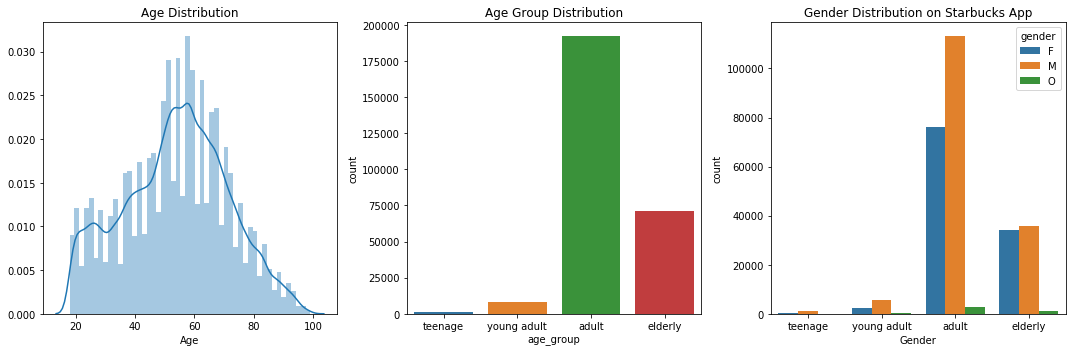

In [51]:
# customer age distribution
plt.figure(figsize=(15,5))

# plt.subplot(row_col_index)
plt.subplot(131)
sns.distplot(df['age'])
plt.xlabel('Age')
plt.title('Age Distribution');

plt.subplot(132)
sns.countplot(df['age_group'])
plt.title('Age Group Distribution')

plt.subplot(133)
sns.countplot(df['age_group'],hue=df['gender'])
plt.xlabel('Gender')
plt.title('Gender Distribution on Starbucks App')

plt.tight_layout()

### C1.b. Income

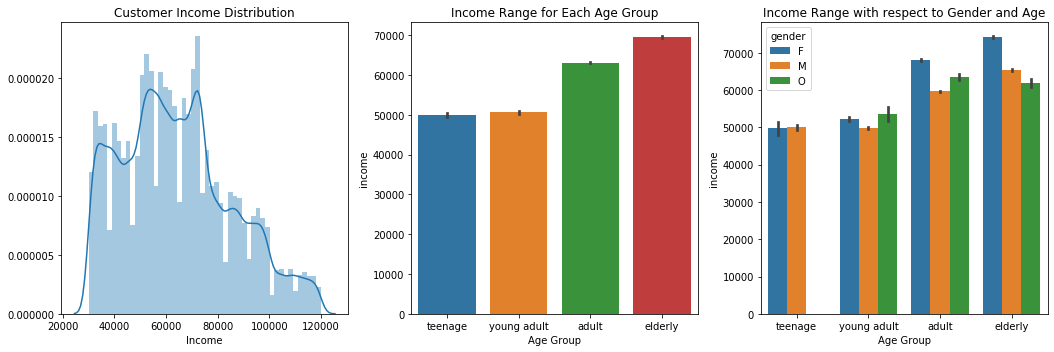

In [52]:
# customer income 
plt.figure(figsize=(15,5))

plt.subplot(131)
sns.distplot(df['income'])
plt.xlabel('Income')
plt.title('Customer Income Distribution');

plt.subplot(132)
sns.barplot(x='age_group',y='income',data=df)
plt.xlabel('Age Group')
plt.title('Income Range for Each Age Group')

plt.subplot(133)
sns.barplot(x='age_group',y='income',data=df, hue=df['gender'])
plt.xlabel('Age Group')
plt.title('Income Range with respect to Gender and Age')

plt.tight_layout()

In [91]:
print('The average customer age using Starbucks app is:',round(df['age'].mean(),0))
print('The meadian customer age using Starbucks app is:',round(df['age'].median(),0))
print('The average average income of customers is: $',round(df['income'].mean(),2))

The average customer age using Starbucks app is: 54.0
The meadian customer age using Starbucks app is: 55.0
The average average income of customers is: $ 64325.54


In [54]:
df['income'].describe()

count    272430.000000
mean      64325.544176
std       21239.121793
min       30000.000000
25%       48000.000000
50%       62000.000000
75%       78000.000000
max      120000.000000
Name: income, dtype: float64

**Insights**
- Most customers are adult ranging from 21-65 years of age
- The IQR of income is 48,000 - 78,000 USD
- Customers who mostly engaged with the app are male adult (same trend in teenage, young adult, adult)
- Within each gender, female is reported to earn more than male and other

## C2. Transactions

This is a group of customers who make purchase without using offers

In [55]:
transactions.head()

customer_id        event  day offer_id  amount gender  age  \
12654         U42  transaction    0      NaN    0.83      F   20   
12657         U56  transaction    0      NaN   34.56      M   42   
12659         U64  transaction    0      NaN   13.23      M   36   
12670        U135  transaction    0      NaN   19.51      F   55   
12671        U152  transaction    0      NaN   18.97      F   39   

      became_member_on   income  reward  difficulty  duration offer_type  \
12654       2016-07-11  30000.0     NaN         NaN       NaN        NaN   
12657       2016-01-17  96000.0     NaN         NaN       NaN        NaN   
12659       2017-12-28  56000.0     NaN         NaN       NaN        NaN   
12670       2017-10-16  94000.0     NaN         NaN       NaN        NaN   
12671       2017-12-17  67000.0     NaN         NaN       NaN        NaN   

       channel_email  channel_mobile  channel_social  channel_web    age_group  
12654            NaN             NaN             NaN          NaN  young adult  
12657            NaN             NaN             NaN          NaN        adult  
12659            NaN             NaN             NaN          NaN        adult  
12670            NaN             NaN             NaN          NaN        adult  
12671            NaN             NaN             NaN          NaN        adult

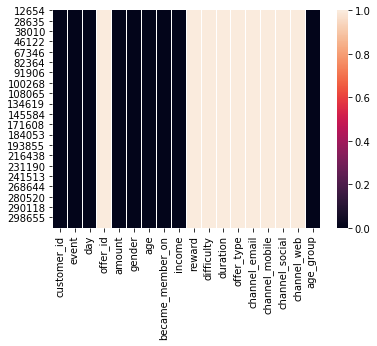

In [56]:
sns.heatmap(transactions.isnull())

### C2.a. EDA 

In [57]:
trans_chars = transactions[['customer_id','event','day','amount','gender','age','became_member_on','income','age_group']]
trans_chars.head()

customer_id        event  day  amount gender  age became_member_on  \
12654         U42  transaction    0    0.83      F   20       2016-07-11   
12657         U56  transaction    0   34.56      M   42       2016-01-17   
12659         U64  transaction    0   13.23      M   36       2017-12-28   
12670        U135  transaction    0   19.51      F   55       2017-10-16   
12671        U152  transaction    0   18.97      F   39       2017-12-17   

        income    age_group  
12654  30000.0  young adult  
12657  96000.0        adult  
12659  56000.0        adult  
12670  94000.0        adult  
12671  67000.0        adult

Transactions made with respect to Gender


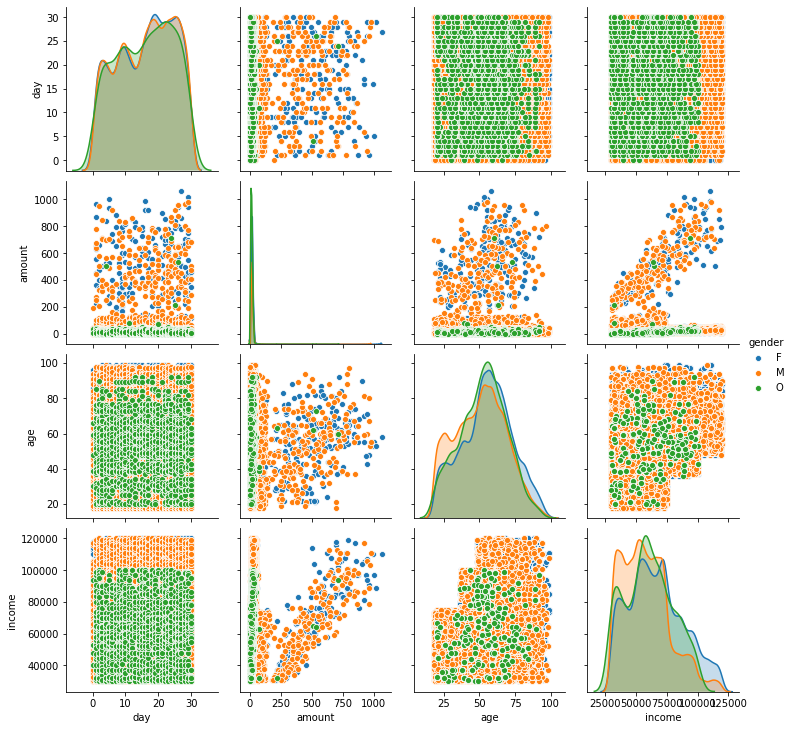

In [58]:
print('Transactions made with respect to Gender')
sns.pairplot(trans_chars,hue='gender')

Transactions made with respect to Age Group


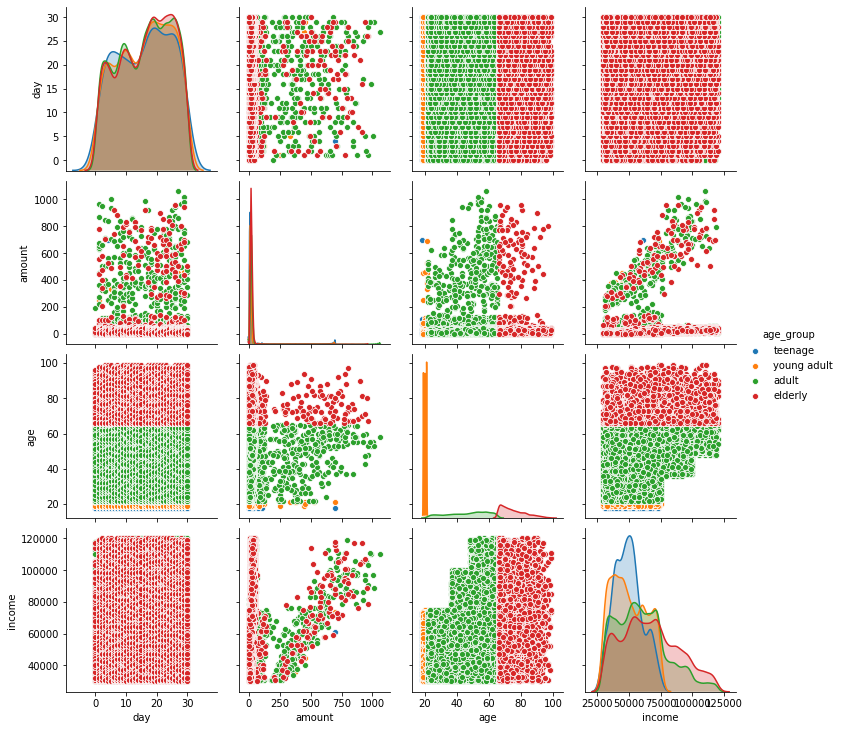

In [59]:
print('Transactions made with respect to Age Group')
sns.pairplot(trans_chars,hue='age_group')

### C2.b. Conclusion

**Description**
- Transaction group represents users who make purchases without using offers.
- Most relavant features are: age, gender, income, and amount spent.

**Findings** <br>
- Most transactions are under 200 USD
- Linear relationship is observed between income and the amount spent

- Gender observations:
    - For purchase > 200 USD, M and F show a correlation between amount spent - income
    - Other gender spends less than 100 USD on average
    - Most male whose income less than 75,000 USD spend up to 200 USD on purchase
    
- Age group observations:
    - Young adult generally spends less than other age groups
    - For purchase > 200 USD, adult and elderly show a correlation between amount spent - income

## C3. Offers

This is a group of customers received offers 

In [60]:
offers.head()

customer_id           event  day offer_id  amount gender  age  \
0          U4  offer received    0       X1     NaN      F   75   
2          U6  offer received    0       X2     NaN      M   68   
5          U9  offer received    0       X3     NaN      M   65   
7         U13  offer received    0       X4     NaN      M   58   
8         U14  offer received    0       X5     NaN      F   61   

  became_member_on    income  reward  difficulty  duration     offer_type  \
0       2017-05-09  100000.0     5.0         5.0       7.0           bogo   
2       2018-04-26   70000.0     2.0        10.0       7.0       discount   
5       2018-02-09   53000.0     5.0         5.0       5.0           bogo   
7       2017-11-11   51000.0     0.0         0.0       4.0  informational   
8       2017-09-11   57000.0     5.0        20.0      10.0       discount   

   channel_email  channel_mobile  channel_social  channel_web age_group  
0            1.0             1.0             0.0          1.0   elderly  
2            1.0             1.0             0.0          1.0   elderly  
5            1.0             1.0             1.0          1.0     adult  
7            1.0             1.0             0.0          1.0     adult  
8            1.0             0.0             0.0          1.0     adult

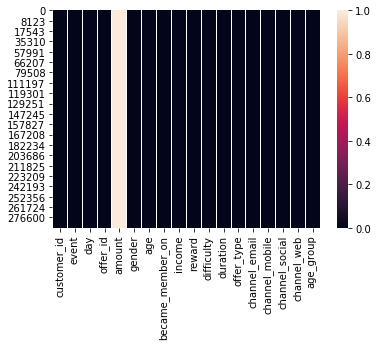

In [61]:
sns.heatmap(offers.isnull())

In [62]:
offer_chars = offers.copy()
offer_chars.drop(['customer_id','amount'], axis=1, inplace=True)
offer_chars.head()

event  day offer_id gender  age became_member_on    income  \
0  offer received    0       X1      F   75       2017-05-09  100000.0   
2  offer received    0       X2      M   68       2018-04-26   70000.0   
5  offer received    0       X3      M   65       2018-02-09   53000.0   
7  offer received    0       X4      M   58       2017-11-11   51000.0   
8  offer received    0       X5      F   61       2017-09-11   57000.0   

   reward  difficulty  duration     offer_type  channel_email  channel_mobile  \
0     5.0         5.0       7.0           bogo            1.0             1.0   
2     2.0        10.0       7.0       discount            1.0             1.0   
5     5.0         5.0       5.0           bogo            1.0             1.0   
7     0.0         0.0       4.0  informational            1.0             1.0   
8     5.0        20.0      10.0       discount            1.0             0.0   

   channel_social  channel_web age_group  
0             0.0          1.0   elderly  
2             0.0          1.0   elderly  
5             1.0          1.0     adult  
7             0.0          1.0     adult  
8             0.0          1.0     adult

### C3.a. EDA

In [63]:
fig = make_subplots(rows=1, cols=2, specs=[[{"type": "pie"}, {"type": "pie"}]])

# create labels
labels_type = offer_chars['offer_type'].value_counts().index
labels_event = offer_chars['event'].value_counts().index

# create figures
fig.add_trace(go.Pie(
     values= offer_chars['offer_type'].value_counts(),
     labels= labels_type,
     name="Offer Types"), 
     row=1, col=1)

fig.add_trace(go.Pie(
     values= offer_chars['event'].value_counts(),
     labels= labels_event,
     name="Event"),
    row=1, col=2)

print('\n Distribution of Offer Types (L) and Customers Response to Offers (R)')
fig.show()


 Distribution of Offer Types (L) and Customers Response to Offers (R)


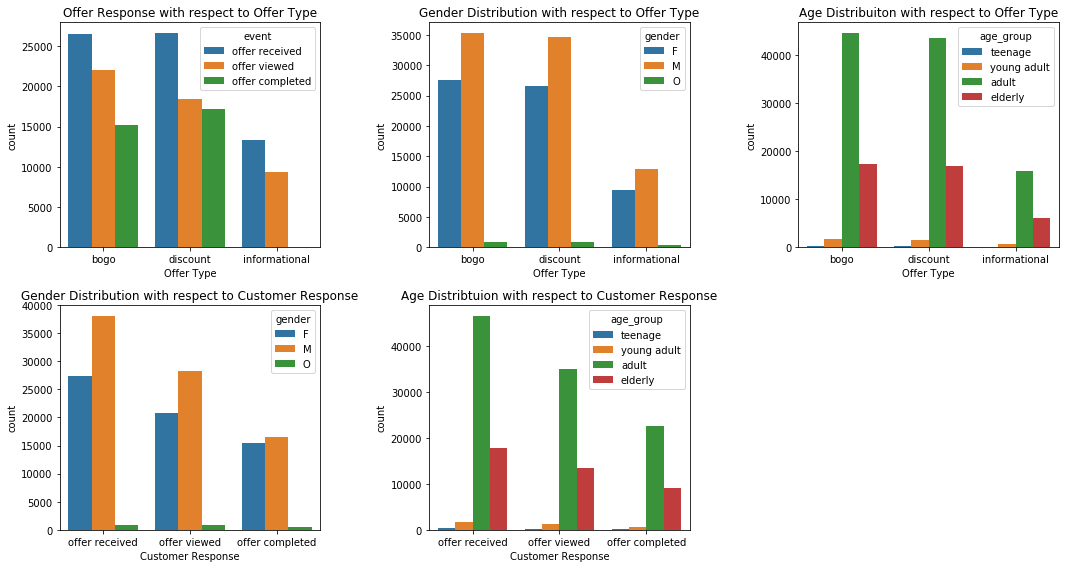

In [64]:
plt.figure(figsize=(15,8))

## Offer Type
# type vs response
plt.subplot(231)
sns.countplot(offer_chars['offer_type'], hue=offer_chars['event'])
plt.xlabel('Offer Type')
plt.title('Offer Response with respect to Offer Type');

# type vs gender
plt.subplot(232)
sns.countplot(offer_chars['offer_type'], hue=offer_chars['gender'])
plt.xlabel('Offer Type')
plt.title('Gender Distribution with respect to Offer Type');

# type vs age
plt.subplot(233)
sns.countplot(offer_chars['offer_type'], hue=offer_chars['age_group'])
plt.xlabel('Offer Type')
plt.title('Age Distribuiton with respect to Offer Type');


## Customer Response (event)
# response vs gender
plt.subplot(234)
sns.countplot(offer_chars['event'], hue=offer_chars['gender'])
plt.xlabel('Customer Response')
plt.title('Gender Distribution with respect to Customer Response');

# response vs age
plt.subplot(235)
sns.countplot(offer_chars['event'], hue=offer_chars['age_group'])
plt.xlabel('Customer Response')
plt.title('Age Distribtuion with respect to Customer Response');

plt.tight_layout()

### C3.b. Insights

- Dominant offers are BOGO (42.9%) and Discount (41.9%)
- Offers target adult as main audience
- Males receive more offers compared to fmales and other.
- Male adults are more responsive to offers.

**Rate**
- Purchase usually comes from Discount then BOGO
- View rate = 33.5%
- Purchase rate (conversion rate) = 21.8%

### C3.c. EDA (cont)

In [65]:
offer_chars.head()

event  day offer_id gender  age became_member_on    income  \
0  offer received    0       X1      F   75       2017-05-09  100000.0   
2  offer received    0       X2      M   68       2018-04-26   70000.0   
5  offer received    0       X3      M   65       2018-02-09   53000.0   
7  offer received    0       X4      M   58       2017-11-11   51000.0   
8  offer received    0       X5      F   61       2017-09-11   57000.0   

   reward  difficulty  duration     offer_type  channel_email  channel_mobile  \
0     5.0         5.0       7.0           bogo            1.0             1.0   
2     2.0        10.0       7.0       discount            1.0             1.0   
5     5.0         5.0       5.0           bogo            1.0             1.0   
7     0.0         0.0       4.0  informational            1.0             1.0   
8     5.0        20.0      10.0       discount            1.0             0.0   

   channel_social  channel_web age_group  
0             0.0          1.0   elderly  
2             0.0          1.0   elderly  
5             1.0          1.0     adult  
7             0.0          1.0     adult  
8             0.0          1.0     adult

In [66]:
# Customers df
cust_df = offer_chars.copy()
cust_df.drop(['age','became_member_on','difficulty'],axis=1, inplace=True)

cust_df.head()

event  day offer_id gender    income  reward  duration  \
0  offer received    0       X1      F  100000.0     5.0       7.0   
2  offer received    0       X2      M   70000.0     2.0       7.0   
5  offer received    0       X3      M   53000.0     5.0       5.0   
7  offer received    0       X4      M   51000.0     0.0       4.0   
8  offer received    0       X5      F   57000.0     5.0      10.0   

      offer_type  channel_email  channel_mobile  channel_social  channel_web  \
0           bogo            1.0             1.0             0.0          1.0   
2       discount            1.0             1.0             0.0          1.0   
5           bogo            1.0             1.0             1.0          1.0   
7  informational            1.0             1.0             0.0          1.0   
8       discount            1.0             0.0             0.0          1.0   

  age_group  
0   elderly  
2   elderly  
5     adult  
7     adult  
8     adult

In [67]:
cust_df.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 148628 entries, 0 to 306527
Data columns (total 13 columns):
 #   Column          Non-Null Count   Dtype   
---  ------          --------------   -----   
 0   event           148628 non-null  object  
 1   day             148628 non-null  int64   
 2   offer_id        148628 non-null  object  
 3   gender          148628 non-null  object  
 4   income          148628 non-null  float64 
 5   reward          148628 non-null  float64 
 6   duration        148628 non-null  float64 
 7   offer_type      148628 non-null  object  
 8   channel_email   148628 non-null  float64 
 9   channel_mobile  148628 non-null  float64 
 10  channel_social  148628 non-null  float64 
 11  channel_web     148628 non-null  float64 
 12  age_group       148628 non-null  category
dtypes: category(1), float64(7), int64(1), object(4)
memory usage: 14.9+ MB


In [68]:
# category cols
cat_cust = cust_df.select_dtypes(include=['object','category'])
cat_cust.drop('offer_id',axis=1,inplace=True)

# create dummies
cat_cust = pd.get_dummies(cat_cust)
col_names = ['offer_completed','offer_received','offer_viewed','gender_F','gender_M','gender_O',
             'bogo','discount','informational',
             'age_teenage','age_ya','age_adult','age_elderly']
cat_cust.columns=col_names

# clean dummied category df
print(cat_cust.shape)
cat_cust.head()

(148628, 13)


offer_completed  offer_received  offer_viewed  gender_F  gender_M  \
0                0               1             0         1         0   
2                0               1             0         0         1   
5                0               1             0         0         1   
7                0               1             0         0         1   
8                0               1             0         1         0   

   gender_O  bogo  discount  informational  age_teenage  age_ya  age_adult  \
0         0     1         0              0            0       0          0   
2         0     0         1              0            0       0          0   
5         0     1         0              0            0       0          1   
7         0     0         0              1            0       0          1   
8         0     0         1              0            0       0          1   

   age_elderly  
0            1  
2            1  
5            0  
7            0  
8            0

In [69]:
# numerical df
num_cust = cust_df.select_dtypes(include=['int64','float64'])

print(num_cust.shape)
num_cust.head()

(148628, 8)


day    income  reward  duration  channel_email  channel_mobile  \
0    0  100000.0     5.0       7.0            1.0             1.0   
2    0   70000.0     2.0       7.0            1.0             1.0   
5    0   53000.0     5.0       5.0            1.0             1.0   
7    0   51000.0     0.0       4.0            1.0             1.0   
8    0   57000.0     5.0      10.0            1.0             0.0   

   channel_social  channel_web  
0             0.0          1.0  
2             0.0          1.0  
5             1.0          1.0  
7             0.0          1.0  
8             0.0          1.0

In [71]:
# Concatenate processed cat and num dfs
cust_df1 = pd.concat([cust_df['offer_id'],num_cust,cat_cust],axis=1)
cust_df1.head()

offer_id  day    income  reward  duration  channel_email  channel_mobile  \
0       X1    0  100000.0     5.0       7.0            1.0             1.0   
2       X2    0   70000.0     2.0       7.0            1.0             1.0   
5       X3    0   53000.0     5.0       5.0            1.0             1.0   
7       X4    0   51000.0     0.0       4.0            1.0             1.0   
8       X5    0   57000.0     5.0      10.0            1.0             0.0   

   channel_social  channel_web  offer_completed  ...  gender_F  gender_M  \
0             0.0          1.0                0  ...         1         0   
2             0.0          1.0                0  ...         0         1   
5             1.0          1.0                0  ...         0         1   
7             0.0          1.0                0  ...         0         1   
8             0.0          1.0                0  ...         1         0   

   gender_O  bogo  discount  informational  age_teenage  age_ya  age_adult  \
0         0     1         0              0            0       0          0   
2         0     0         1              0            0       0          0   
5         0     1         0              0            0       0          1   
7         0     0         0              1            0       0          1   
8         0     0         1              0            0       0          1   

   age_elderly  
0            1  
2            1  
5            0  
7            0  
8            0  

[5 rows x 22 columns]

In [72]:
# Completed offer is the record of customer converted
cust_df1.rename(columns = {'offer_completed':'converted'}, inplace = True)
cust_df1.head()

offer_id  day    income  reward  duration  channel_email  channel_mobile  \
0       X1    0  100000.0     5.0       7.0            1.0             1.0   
2       X2    0   70000.0     2.0       7.0            1.0             1.0   
5       X3    0   53000.0     5.0       5.0            1.0             1.0   
7       X4    0   51000.0     0.0       4.0            1.0             1.0   
8       X5    0   57000.0     5.0      10.0            1.0             0.0   

   channel_social  channel_web  converted  ...  gender_F  gender_M  gender_O  \
0             0.0          1.0          0  ...         1         0         0   
2             0.0          1.0          0  ...         0         1         0   
5             1.0          1.0          0  ...         0         1         0   
7             0.0          1.0          0  ...         0         1         0   
8             0.0          1.0          0  ...         1         0         0   

   bogo  discount  informational  age_teenage  age_ya  age_adult  age_elderly  
0     1         0              0            0       0          0            1  
2     0         1              0            0       0          0            1  
5     1         0              0            0       0          1            0  
7     0         0              1            0       0          1            0  
8     0         1              0            0       0          1            0  

[5 rows x 22 columns]

In [73]:
data = [go.Heatmap(
        z= cust_df1.corr().values,
        x= cust_df1.columns.values,
        y= cust_df1.columns.values,
        colorscale='RdBu_r',
        opacity = 1.0 )]

layout = go.Layout(
    title='Pearson Correlation of Input Features',
    xaxis = dict(ticks='', nticks=36),
    yaxis = dict(ticks=''),
    width = 900, height = 700)

fig = go.Figure(data=data, layout=layout)
fig.show()

In [74]:
# Top 10 features that correlate with Conversion 
cust_df1.corr()['converted'].sort_values(ascending=False)

# channel_web contains only value of 1s -> no variation -> drop

converted         1.000000
duration          0.171724
day               0.130559
discount          0.118759
channel_web       0.107672
reward            0.079189
income            0.074183
gender_F          0.052159
bogo              0.044066
age_elderly       0.013968
gender_O          0.003164
age_teenage      -0.004048
age_adult        -0.007080
channel_social   -0.013735
age_ya           -0.017200
channel_mobile   -0.041276
gender_M         -0.052723
informational    -0.223771
offer_viewed     -0.374797
offer_received   -0.474616
channel_email          NaN
Name: converted, dtype: float64

### C3.d. Conclusions

Features that influence the customers response to make purchase using offers are: 
- duration: valid period of offers
- discount offer
- offers advertised on website
- reward value
- customer income
- females, despite earlier observation that males receive more offers and more responsive (i.e. view the offers)
- BOGO offer

# D. Modeling

AIM: Confirm the effectivness of the current user-targeting and promo-offering stratagies used by starbucks
Method: Apply logistic regression model to measure conversion accuracy. Use established metrics as baseline for future A/B testing

In [92]:
final_df = cust_df1.copy()

# Drop irrelevant columns
final_df.drop(['offer_id','channel_email'],axis=1,inplace=True)
final_df.head()

day    income  reward  duration  channel_mobile  channel_social  \
0    0  100000.0     5.0       7.0             1.0             0.0   
2    0   70000.0     2.0       7.0             1.0             0.0   
5    0   53000.0     5.0       5.0             1.0             1.0   
7    0   51000.0     0.0       4.0             1.0             0.0   
8    0   57000.0     5.0      10.0             0.0             0.0   

   channel_web  converted  offer_received  offer_viewed  gender_F  gender_M  \
0          1.0          0               1             0         1         0   
2          1.0          0               1             0         0         1   
5          1.0          0               1             0         0         1   
7          1.0          0               1             0         0         1   
8          1.0          0               1             0         1         0   

   gender_O  bogo  discount  informational  age_teenage  age_ya  age_adult  \
0         0     1         0              0            0       0          0   
2         0     0         1              0            0       0          0   
5         0     1         0              0            0       0          1   
7         0     0         0              1            0       0          1   
8         0     0         1              0            0       0          1   

   age_elderly  
0            1  
2            1  
5            0  
7            0  
8            0

In [76]:
final_df['converted'].value_counts()

0    116229
1     32399
Name: converted, dtype: int64

**Recall**: conversion rate is 21.8%, which indicates we have high imbalance dataset (0s > 1s)

## D1. Train - Test Split

In [77]:
X = final_df.drop('converted',axis=1)
y = final_df['converted']

In [78]:
X_train, X_val, y_train, y_val = train_test_split(X, y, test_size=0.3, random_state=42)

In [79]:
# Instantiate the Logistic Regression Model
logmodel = LogisticRegression()
logmodel.fit(X_train,y_train)

LogisticRegression()

## D2. Train the model
Apply cross validation with k-fold = 10 on the train set

In [80]:
y_train_pred = cross_val_predict(logmodel, X_train, y_train, cv=10)

print('Classification Report on the training set')
print(classification_report(y_train,y_train_pred))

Classification Report on the training set
              precision    recall  f1-score   support

           0       0.78      1.00      0.88     81352
           1       0.00      0.00      0.00     22687

    accuracy                           0.78    104039
   macro avg       0.39      0.50      0.44    104039
weighted avg       0.61      0.78      0.69    104039



### D3. Test the model

In [93]:
# Apply the model on X_val
y_val_pred = logmodel.predict(X_val)

print('Classification Report on the validation set')
print(classification_report(y_val,y_val_pred))

Classification Report on the validation set
              precision    recall  f1-score   support

           0       0.78      1.00      0.88     34877
           1       0.00      0.00      0.00      9712

    accuracy                           0.78     44589
   macro avg       0.39      0.50      0.44     44589
weighted avg       0.61      0.78      0.69     44589



###  Model accuracy is 78% on both train and validation sets

# E. Conclusion and Discussion

At a high level, purchases made on the Starbucks reward apps carry some charactersistics:
- The dominant customers are adult (21-65 yr) and elderly (> 65 yr)
- Male makes more purchase compared to other genders (female, other, unspecified)
- Most amount spent is up to 200 USD
- Amount spent is incorrelation with customers' incomes.

### How effective are the offers?

- Currently, recorded transaction made **without use of offers is 45%**. 
- Under **influence of offers** (BOGO, discount, and informational):
    - current converion rate is 21.8%**
    - view rate is 33.5%

The logistic regression model produces an accuracy scores of 78% on both train and validation data sets. This indicates that the model is effective enough to predict the conversion rate of customers who receive offers. 

### Offer personalization

Based on the extensive EDA, **two groups of customers** found to be responsive to offers and likely to make purchase (convert).

**Male Adult**: 
- most responsive (received, viewed) to offers
- is also currently the target audience to receive many offers compared to other genders in all age group

**Female Adult**:
- most likely to make a purchase using offers (completed)

We can continue to send out offers that are **discount and BOGO** since they drive customers' buying decisions. The reward value also excite customers.

The source of offers that highly correlates with conversion rate is **website**. Here is the cue that we should focus on optimizing the presentation of offers on Starbucks homepage.

### Next steps

More sophisticated strategies could be employed to achieve a higher conversion rate among Starbucks customers. Uplift modeling can be used to identify the right customer group for a specific promotion. The uplift model method of "two classifiers" can be used. The process will consist of two steps: 

1. Conduct a randomized A/B test, in which the treatment group of customers receives and offers and the control group does not. Train classifiers to predict the likelihood (probability) of conversion for both groups. Add two classifiers into one using a special library (upliftML , casualML). Use a combined classifier on the entire customer base to identify customers with high conversion probability.
2. Conduct a second A/B test, in which the treatment group is customers with a high conversion probability receive promo offers and the control group consisting of random customers also receive promo offers. Calculate lift as the difference in total conversion or total amount spent. 

This method allows for more quantitative customer segmentation and promo offerings, rather than qualitative, human-decision-based strategies.   

